In [46]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic
# from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
# from sklearn.model_selection import train_test_split
# from skopt import BayesSearchCV
# from skopt.space import Categorical
#
#
# from sklearn.metrics import mean_squared_error, r2_score

data_dir = 'data'

In [59]:
def compute_kernel(X, Y, kernel: kernels.Kernel):
    """
    Compute the kernel matrix for the given data and kernel.

    Parameters:
    X : array-like, shape (n_samples_X, n_features)
        First set of samples.
    Y : array-like, shape (n_samples_Y, n_features)
        Second set of samples.
    kernel : kernels.Kernel
        The kernel function to use for computing the kernel matrix.

    Returns:
    K : array-like, shape (n_samples_X, n_samples_Y)
        The kernel matrix computed between X and Y.
    """
    return kernel(X, Y)

def compute_mmd(X, Y, kernel: kernels.Kernel):
    """
    Compute the Maximum Mean Discrepancy (MMD) between two distributions using the specified kernel.
    """
    K_XX = compute_kernel(X, X, kernel)
    K_YY = compute_kernel(Y, Y, kernel)
    K_XY = compute_kernel(X, Y, kernel)

    mmd = np.mean(K_XX) + np.mean(K_YY) - 2 * np.mean(K_XY)
    return mmd

In [53]:
df = pd.read_csv(os.path.join(data_dir, 'CSF_COG_PET_data_cleaned.csv'))
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 187 columns):
 #    Column                         Dtype  
---   ------                         -----  
 0    TAU_bl                         float64
 1    PTAU_bl                        float64
 2    ABETA_bl                       float64
 3    DX_bl                          int64  
 4    DX                             int64  
 5    AGE                            float64
 6    PTGENDER                       int64  
 7    PTEDUCAT                       int64  
 8    MMSE_bl                        float64
 9    EcogPtTotal_bl                 float64
 10   FHQMOM                         float64
 11   FHQMOMAD                       float64
 12   FHQDAD                         float64
 13   FHQDADAD                       float64
 14   LDELTOTAL_BL                   float64
 15   mPACCdigit_bl                  float64
 16   mPACCtrailsB_bl                float64
 17   RAVLT_immediate_bl             fl

In [54]:
df['PTEDUCAT'].value_counts()

PTEDUCAT
16    138
18    101
20     85
12     64
14     59
19     30
17     25
15     20
13     16
11      2
10      1
9       1
8       1
Name: count, dtype: int64

In [62]:
# Split the data into two sets based on the 'PTEDUCAT' column - below 15 and above 15
uni_education_df = df[df['PTEDUCAT'] > 15]
school_education_df = df[df['PTEDUCAT'] <= 15]

In [63]:
uni_education_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 379 entries, 0 to 542
Columns: 187 entries, TAU_bl to SUVr_VTA_R.nii
dtypes: float64(183), int64(4)
memory usage: 556.7 KB


In [64]:
school_education_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 1 to 539
Columns: 187 entries, TAU_bl to SUVr_VTA_R.nii
dtypes: float64(183), int64(4)
memory usage: 240.9 KB


In [76]:
# Define the kernel to be used for MMD computation
kernel = RBF(length_scale=1.0)

In [81]:
# Compute MMD between the training and test sets
mmd_education = compute_mmd(uni_education_df, school_education_df, kernel)
print(f'MMD between training and test sets: {mmd_education:.4f}')

MMD between training and test sets: 0.0087


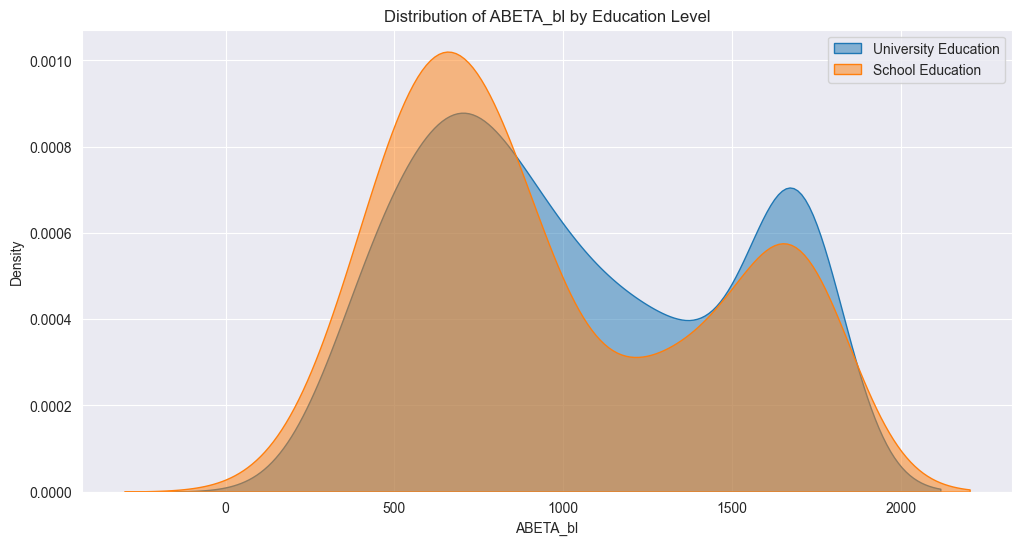

In [66]:
# Visualize the distributions of the two groups
plt.figure(figsize=(12, 6))
sns.kdeplot(uni_education_df['ABETA_bl'], label='University Education', fill=True, alpha=0.5)
sns.kdeplot(school_education_df['ABETA_bl'], label='School Education', fill=True, alpha=0.5)
plt.title('Distribution of ABETA_bl by Education Level')
plt.xlabel('ABETA_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

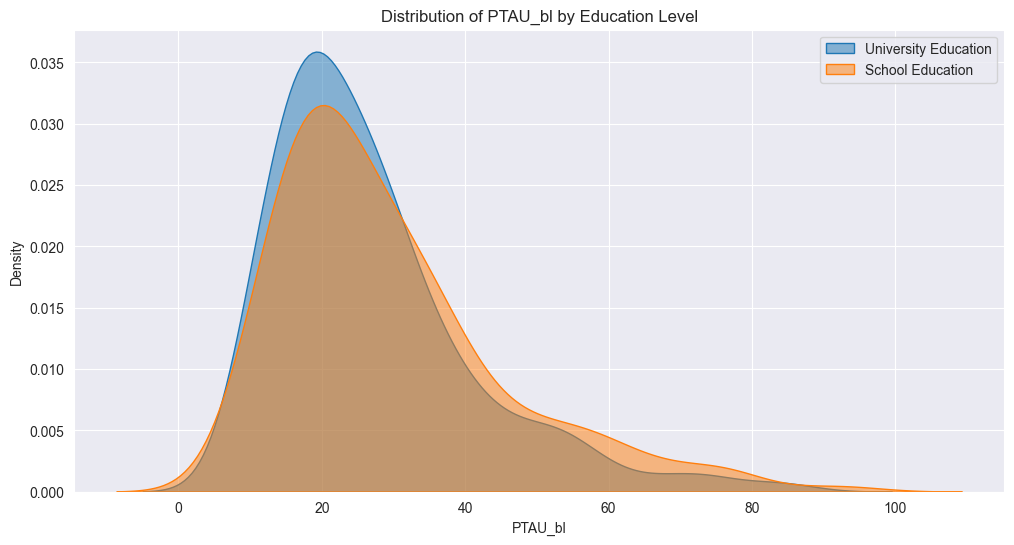

In [89]:
# Visualize the distributions of the two groups
plt.figure(figsize=(12, 6))
sns.kdeplot(uni_education_df['PTAU_bl'], label='University Education', fill=True, alpha=0.5)
sns.kdeplot(school_education_df['PTAU_bl'], label='School Education', fill=True, alpha=0.5)
plt.title('Distribution of PTAU_bl by Education Level')
plt.xlabel('PTAU_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

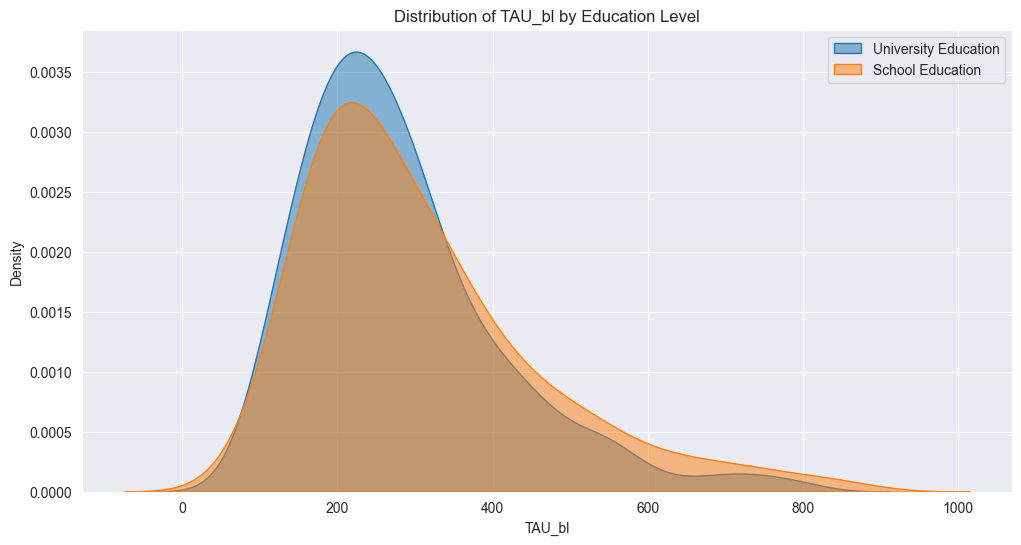

In [90]:
# Visualize the distributions of the two groups
plt.figure(figsize=(12, 6))
sns.kdeplot(uni_education_df['TAU_bl'], label='University Education', fill=True, alpha=0.5)
sns.kdeplot(school_education_df['TAU_bl'], label='School Education', fill=True, alpha=0.5)
plt.title('Distribution of TAU_bl by Education Level')
plt.xlabel('TAU_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

In [78]:
older_age_df = df[df['AGE'] > 70]
younger_age_df = df[df['AGE'] <= 70]

In [79]:
older_age_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 351 entries, 1 to 541
Columns: 187 entries, TAU_bl to SUVr_VTA_R.nii
dtypes: float64(183), int64(4)
memory usage: 515.5 KB


In [80]:
younger_age_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192 entries, 0 to 542
Columns: 187 entries, TAU_bl to SUVr_VTA_R.nii
dtypes: float64(183), int64(4)
memory usage: 282.0 KB


In [82]:
mmd_age = compute_mmd(older_age_df, younger_age_df, kernel)
print(f'MMD between older and younger age groups: {mmd_age:.4f}')

MMD between older and younger age groups: 0.0081


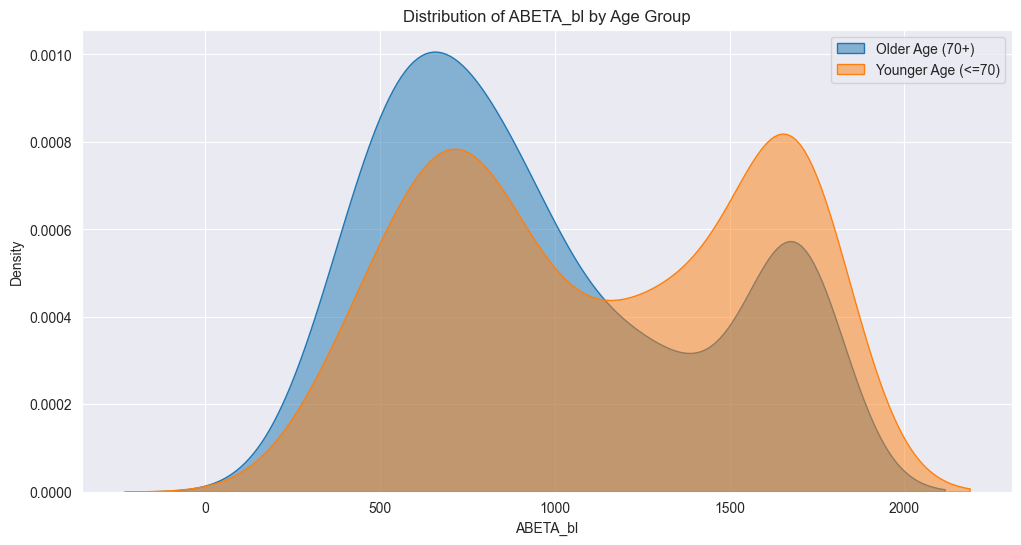

In [83]:
# Visualize the distributions of the two age groups
plt.figure(figsize=(12, 6))
sns.kdeplot(older_age_df['ABETA_bl'], label='Older Age (70+)', fill=True, alpha=0.5)
sns.kdeplot(younger_age_df['ABETA_bl'], label='Younger Age (<=70)', fill=True, alpha=0.5)
plt.title('Distribution of ABETA_bl by Age Group')
plt.xlabel('ABETA_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

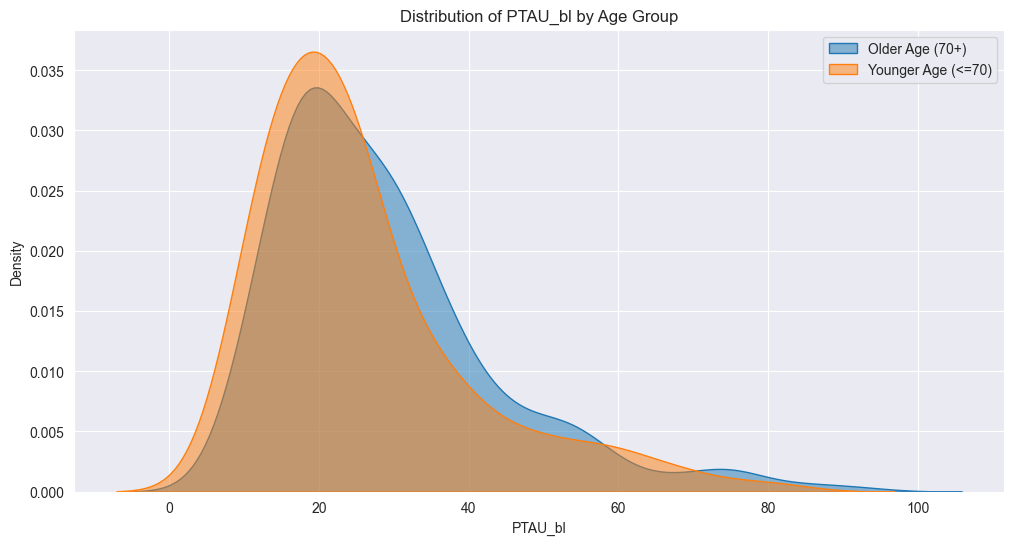

In [91]:
# Visualize the distributions of the two age groups
plt.figure(figsize=(12, 6))
sns.kdeplot(older_age_df['PTAU_bl'], label='Older Age (70+)', fill=True, alpha=0.5)
sns.kdeplot(younger_age_df['PTAU_bl'], label='Younger Age (<=70)', fill=True, alpha=0.5)
plt.title('Distribution of PTAU_bl by Age Group')
plt.xlabel('PTAU_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

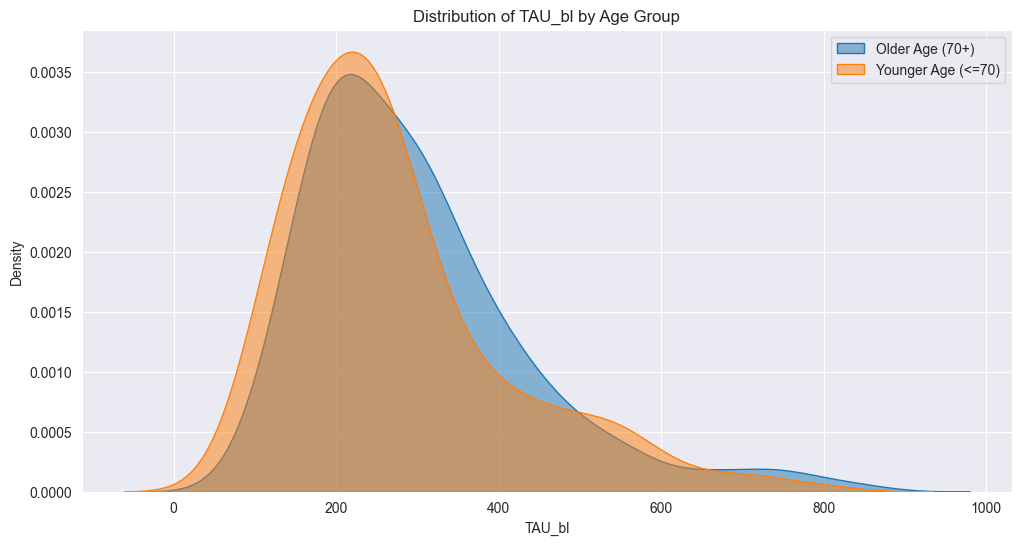

In [92]:
# Visualize the distributions of the two age groups
plt.figure(figsize=(12, 6))
sns.kdeplot(older_age_df['TAU_bl'], label='Older Age (70+)', fill=True, alpha=0.5)
sns.kdeplot(younger_age_df['TAU_bl'], label='Younger Age (<=70)', fill=True, alpha=0.5)
plt.title('Distribution of TAU_bl by Age Group')
plt.xlabel('TAU_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

In [84]:
male_df = df[df['PTGENDER'] == 0]
female_df = df[df['PTGENDER'] == 1]

In [85]:
male_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286 entries, 0 to 542
Columns: 187 entries, TAU_bl to SUVr_VTA_R.nii
dtypes: float64(183), int64(4)
memory usage: 420.1 KB


In [86]:
female_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257 entries, 1 to 541
Columns: 187 entries, TAU_bl to SUVr_VTA_R.nii
dtypes: float64(183), int64(4)
memory usage: 377.5 KB


In [87]:
mmd_gender = compute_mmd(male_df, female_df, kernel)
print(f'MMD between males and females: {mmd_gender}')

MMD between males and females: 0.007387554080161084


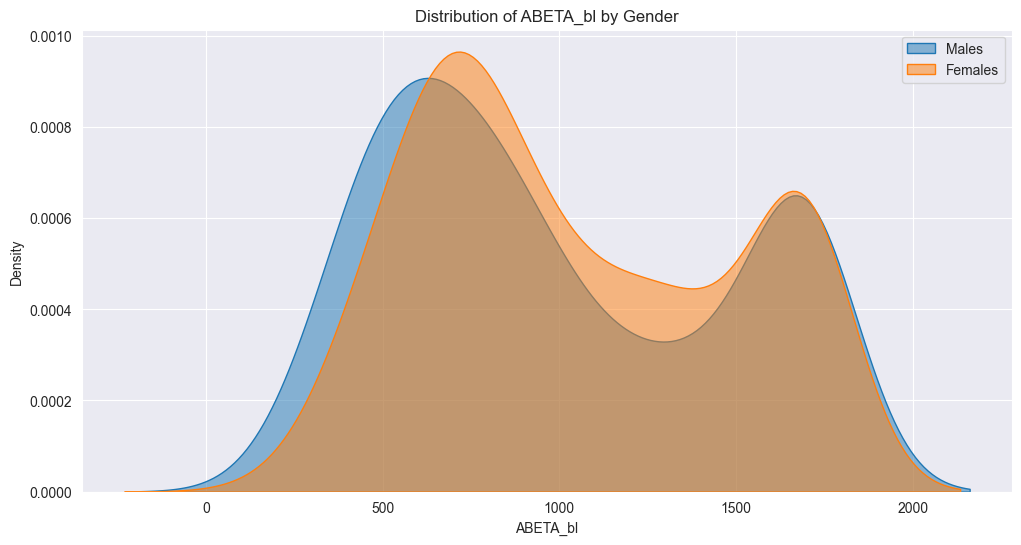

In [88]:
# Visualize the distributions of the two genders
plt.figure(figsize=(12, 6))
sns.kdeplot(male_df['ABETA_bl'], label='Males', fill=True, alpha=0.5)
sns.kdeplot(female_df['ABETA_bl'], label='Females', fill=True, alpha=0.5)
plt.title('Distribution of ABETA_bl by Gender')
plt.xlabel('ABETA_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

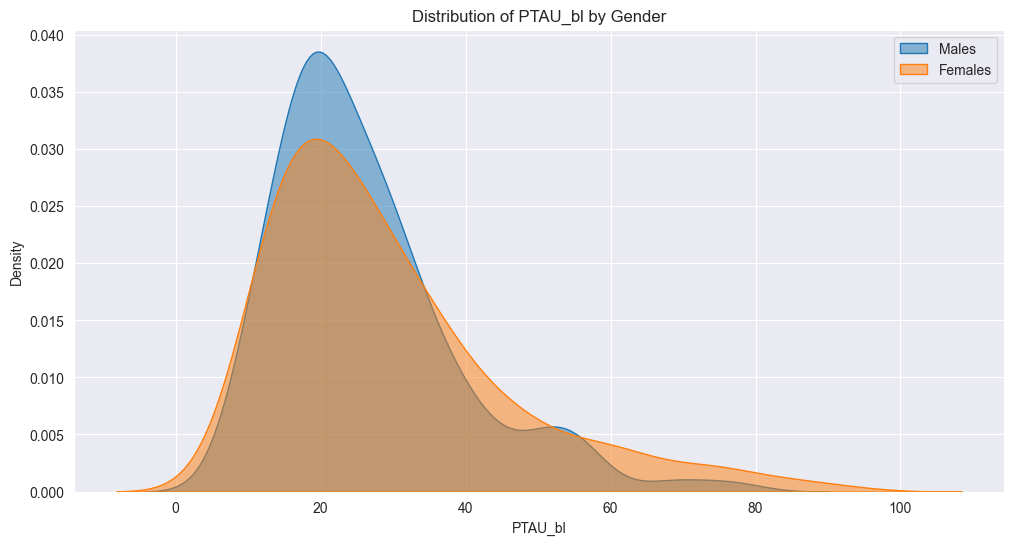

In [93]:
# Visualize the distributions of the two genders
plt.figure(figsize=(12, 6))
sns.kdeplot(male_df['PTAU_bl'], label='Males', fill=True, alpha=0.5)
sns.kdeplot(female_df['PTAU_bl'], label='Females', fill=True, alpha=0.5)
plt.title('Distribution of PTAU_bl by Gender')
plt.xlabel('PTAU_bl')
plt.ylabel('Density')
plt.legend()
plt.show()

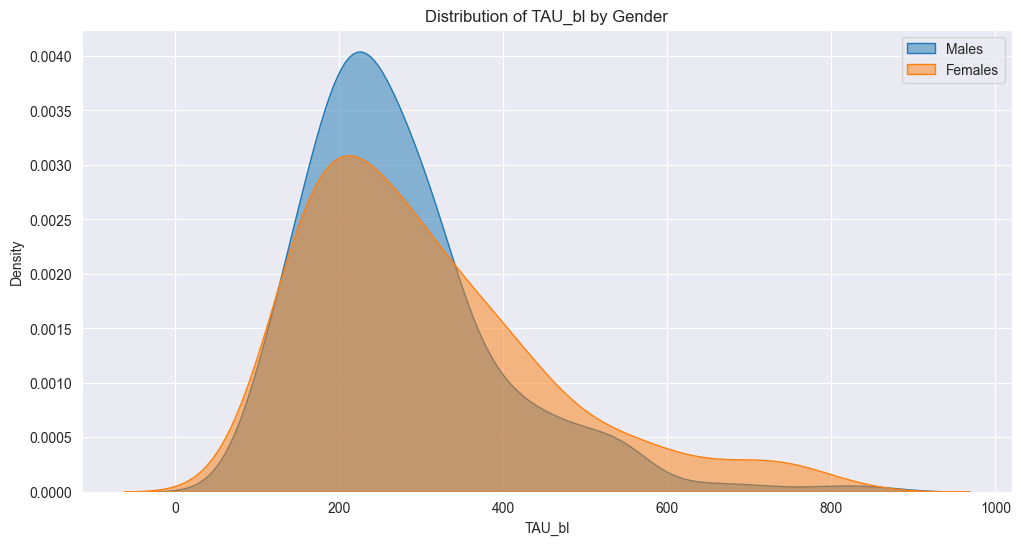

In [94]:
# Visualize the distributions of the two genders
plt.figure(figsize=(12, 6))
sns.kdeplot(male_df['TAU_bl'], label='Males', fill=True, alpha=0.5)
sns.kdeplot(female_df['TAU_bl'], label='Females', fill=True, alpha=0.5)
plt.title('Distribution of TAU_bl by Gender')
plt.xlabel('TAU_bl')
plt.ylabel('Density')
plt.legend()
plt.show()